In [2]:
pip install torch

  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchprofile 0.0.1 requires torchvision>=0.4, which is not installed.
torchtext 0.9.1 requires torch==1.8.1, but you have torch 1.13.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchvision

  Using cached torchvision-0.14.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [19]:
data_folder = "data_10images_250by250pixels_upto20pins_4seed"
d1 = 250
d2 = 250

In [52]:
pins_file = f"{data_folder}/pins.csv"
pins_df = pd.read_csv(pins_file)
pins_df

,image,pins,outputs
0,0.png,"[(58, 44), (103, 38), (109, 126), (94, 234), (...","[13.321287777481384, 10.331109217685984, 12.65..."
1,1.png,"[(234, 107), (199, 51), (201, 8), (210, 249), ...","[-6.727107254193989, 9.965960802840137, -6.696..."
2,2.png,"[(59, 120), (52, 248), (52, 49), (192, 159), (...","[9.197233466437734, 9.081367971689373, 19.2589..."
3,3.png,"[(144, 135), (179, 27), (204, 243), (204, 217)...","[24.981726149026244, 16.64823970438521, 9.9843..."
4,4.png,"[(210, 183), (65, 95), (147, 148)]","[-9.296217859684825, 34.07365420054031, 39.338..."
5,5.png,"[(30, 208), (182, 37), (182, 29), (113, 2), (1...","[17.63066994513298, 2.3452045961445602, 7.3520..."
6,6.png,"[(207, 110), (28, 215), (16, 86), (137, 113)]","[5.575742570009623, 14.59398798189891, 15.2501..."
7,7.png,"[(130, 38), (94, 173), (73, 125), (112, 128), ...","[18.725307112273455, 5.82288820720303, 25.5763..."
8,8.png,"[(204, 49), (2, 48), (190, 84), (200, 219), (2...","[12.947550541878632, 11.25268651780452, 13.592..."
9,9.png,"[(169, 144), (91, 205), (105, 202), (24, 104),...","[32.63125928564129, 11.634098998399942, 16.259..."


In [48]:
# y_file = f"{data_folder}/y.csv"
# out_df = pd.read_csv(y_file)
# out_df

,image,outputs
0,0.png,"[13.321287777481384, 10.331109217685984, 12.65..."
1,1.png,"[-6.727107254193989, 9.965960802840137, -6.696..."
2,2.png,"[9.197233466437734, 9.081367971689373, 19.2589..."
3,3.png,"[24.981726149026244, 16.64823970438521, 9.9843..."
4,4.png,"[-9.296217859684825, 34.07365420054031, 39.338..."
5,5.png,"[17.63066994513298, 2.3452045961445602, 7.3520..."
6,6.png,"[5.575742570009623, 14.59398798189891, 15.2501..."
7,7.png,"[18.725307112273455, 5.82288820720303, 25.5763..."
8,8.png,"[12.947550541878632, 11.25268651780452, 13.592..."
9,9.png,"[32.63125928564129, 11.634098998399942, 16.259..."


In [53]:
img_name = pins_df.iloc[4, 0]
pins = eval(pins_df.iloc[4, 1])
pins = np.asarray(pins)
pins

array([[210, 183],
       [ 65,  95],
       [147, 148]])

In [54]:
outputs = eval(pins_df.iloc[4, 2])
outputs = np.asarray(outputs)
outputs

array([-9.29621786, 34.0736542 , 39.33899342])

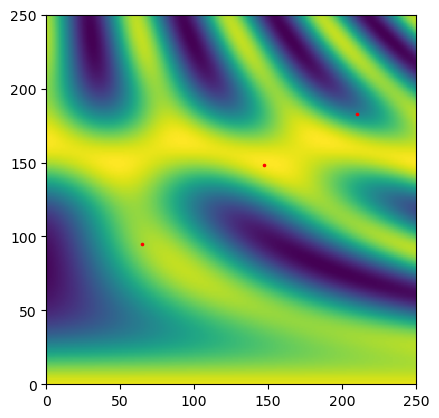

In [68]:
def show_pins(image, pins, outputs):
    """Show image with pins"""
    plt.imshow(image, extent=[0,250,0,250])
    plt.scatter(pins[:, 0], pins[:, 1], s=10, marker='.', c='r')
    # plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_pins(io.imread(f"{data_folder}/images/{img_name}"), pins, outputs)
plt.show()

In [69]:
class SynthHeatmapDataset(Dataset):
    """Synthetic Heatmaps dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pins_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pins_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.pins_frame.iloc[idx, 0])
        image = io.imread(img_name)
        pins = np.asarray(eval(self.pins_frame.iloc[idx, 1]))
        outputs = np.asarray(eval(self.pins_frame.iloc[idx, 2]))

        sample = {'image': image, 'pins': pins, 'outputs': outputs}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (539, 539, 4) (10, 2)
1 (539, 539, 4) (14, 2)
2 (539, 539, 4) (9, 2)
3 (539, 539, 4) (13, 2)


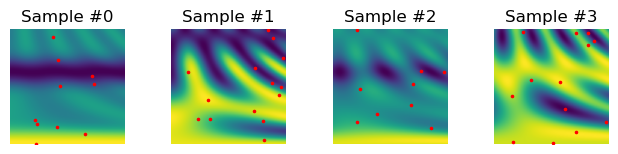

In [70]:
heatmap_dataset = SynthHeatmapDataset(csv_file=f"{data_folder}/pins.csv",
                                      root_dir=f"{data_folder}/images/")

fig = plt.figure()

for i, sample in enumerate(heatmap_dataset):
    print(i, sample['image'].shape, sample['pins'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pins(**sample)

    if i == 3:
        plt.show()
        break

In [71]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, pins, outputs = sample['image'], sample['pins'], sample['outputs']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'pins': torch.from_numpy(pins),
                'outputs': torch.from_numpy(outputs)}

In [72]:
transformed_dataset = SynthHeatmapDataset(csv_file=f"{data_folder}/pins.csv",
                                          root_dir=f"{data_folder}/images/",
                                          transform=transforms.Compose([ToTensor()])
                                         )

for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['pins'].size(), sample['outputs'].size())

    if i == 3:
        break

0 torch.Size([4, 539, 539]) torch.Size([10, 2]) torch.Size([10])
1 torch.Size([4, 539, 539]) torch.Size([14, 2]) torch.Size([14])
2 torch.Size([4, 539, 539]) torch.Size([9, 2]) torch.Size([9])
3 torch.Size([4, 539, 539]) torch.Size([13, 2]) torch.Size([13])
